In [ ]:
【自治体決算情報分析】
目標:財政力指数の要因を見つける.
結論:面積と人口が主要因である.

In [ ]:
【仮説構築】
財政力指数は (基準財政収入額)/(基準財政需要額)から算出される. したがって, 収入・支出に影響を与える項目が財政力指数の要因と考えられる.
基準財政収入額は事業税や住民税など様々な種類があるが, 基本的に人口が大きな要因ではないか。また、産業の種類も関係するのではないか
基準財政需要額はおもに二つ, 教育費など対人のもの, 交通や建造物の維持など対インフラのもの. 前者は人口に, 後者は主に面積などに関わるのではないか.

In [ ]:
実際に分析をしてみると, 産業から強い関係性を見てとることはできなかった. 以下エクセルからデータを取り込んで分析していく.

In [126]:
#分析の用意
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pandas.plotting import scatter_matrix
from scipy.stats import pearsonr, linregress
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
%matplotlib inline
%precision 3

'%.3f'

In [112]:
#ダウンロードしておいたエクセルファイルを読みこみ,データフレーム化
file = pd.ExcelFile('zaisei.xls')
file_sheet_names = file.sheet_names
df = file.parse(file_sheet_names[0])
df.head(10)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(単位 千円)
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,歳入総額,歳出総額,歳入歳出差引額,翌年度に\n繰り越すべき財源,実質収支\n(C)-(D),単年度収支,積立金,繰上償還金,積立金\n取崩し額,実質単年度収支
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
確認してみるとnull値が多いなど問題があり, このままでは扱えないことがわかる. 
エクセルと照らし合わせつつ処理を行う.

In [117]:
df = file.parse(file_sheet_names[0], skiprows=8, skip_footer =12,usecols="O,Q,X:AF,AH,AI,AM,AR,AW", names=range(1,17))
df.set_index(1, inplace=True)

In [118]:
#確認. まだnull値が多い. 欠損値は'-'で表されている.
df.head(20)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1,,,,,,,,,,,,,,,
団体\nコード,住民基本台帳\n登載人口,面積\n(27.10.1現在),基準財政需要額,基準財政収入額,標準財政規模,NaN,実質\n収支比率,経常収支\n比率,左のうち,NaN,公債費\n負担比率,財政力\n指数,NaN,実質収支\n(C)-(D),実質単年度収支
NaN,NaN,NaN,NaN,NaN,NaN,臨時財政対策債 \n発行可能額,NaN,NaN,人件費,公債費,NaN,NaN,将来負担比率,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,(28.1.1現在),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(F)+(G)+(H)-(I)
NaN,(人),(k㎡),NaN,NaN,NaN,NaN,(%),(%),(%),(%),(%),NaN,(%),(E),(J)
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
011002,1941832,1121.26,326840745,239213005,449590664,53241188,0.9,91.6,19.3,17.1,15.7,0.72,61.8,3991299,-614601
012025,268617,677.86,58883567,27485413,72627075,4973554,3.3,87.2,21.2,21.2,19.1,0.46,67.3,2399982,1072827


In [119]:
df.columns = ["population","area","amnt_demand","amnt_income","std_size","can_debt","ratio_actual","ratio_ordinary","pay_man","pay_debt","ratio_debt","power","future_bear","out_in_actual","out_in_annual"]
df = df.replace('-',np.nan).dropna()
df_f = df.astype('float64')

In [122]:
df_f.describe()

,population,area,amnt_demand,amnt_income,std_size,can_debt,ratio_actual,ratio_ordinary,pay_man,pay_debt,ratio_debt,power,future_bear,out_in_actual,out_in_annual
count,6.450000e+02,645.000000,6.450000e+02,6.450000e+02,6.450000e+02,6.450000e+02,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,6.450000e+02,6.450000e+02
mean,3.113391e+05,610.653504,5.157927e+07,3.805475e+07,6.917683e+07,4.908047e+06,5.667752,90.112713,23.587442,17.455504,15.206357,0.601442,65.792093,3.105959e+06,7.874851e+05
std,9.783059e+05,1418.865825,1.378540e+08,1.172180e+08,1.878858e+08,1.361077e+07,4.395818,4.491506,3.335506,4.553381,4.117589,0.211185,49.859379,1.011488e+07,4.024872e+06
min,9.056000e+03,5.110000,4.276430e+06,7.921790e+05,4.755135e+06,7.858600e+04,0.100000,66.400000,13.700000,6.900000,4.200000,0.180000,0.000000,6.909000e+03,-6.135272e+06
25%,4.208200e+04,92.490000,9.258271e+06,4.398637e+06,1.190515e+07,7.289100e+05,3.300000,87.400000,21.300000,14.600000,12.400000,0.430000,31.800000,5.508940e+05,-2.661300e+04
50%,7.147300e+04,215.700000,1.381212e+07,7.962300e+06,1.785370e+07,1.133715e+06,5.200000,90.000000,23.500000,17.300000,15.000000,0.580000,57.900000,9.517060e+05,2.507530e+05
75%,1.601540e+05,514.340000,2.677980e+07,1.890518e+07,3.623312e+07,2.209399e+06,7.300000,93.000000,25.600000,20.100000,17.600000,0.760000,91.600000,1.925305e+06,7.409360e+05
max,1.332995e+07,18536.220000,1.455446e+09,1.284411e+09,1.980708e+09,1.672095e+08,77.100000,120.700000,36.400000,69.200000,40.300000,1.350000,632.400000,1.748628e+08,8.662047e+07


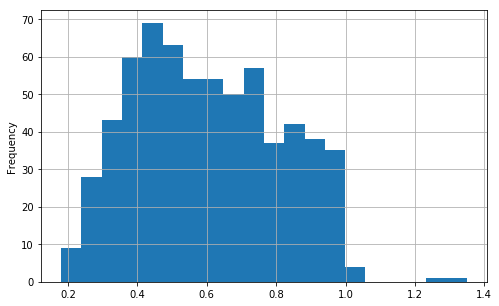

In [123]:
df_f['power'].plot.hist(bins=20,grid=True,figsize=(8,5))

In [37]:
財政力指数は①やや右に歪んでいる②ほとんどが(0,1)の間にあることがわかる.

In [125]:
#素の数字だと大きすぎるので対数をとる
df_f['log_population'] = df_f['population'].apply(np.log)
df_f['log_area'] = df_f['area'].apply(np.log)
df_f['log_amnt_demand'] = df_f['amnt_demand'].apply(np.log)
df_f['log_amnt_income'] = df_f['amnt_income'].apply(np.log)
df_f['log_std_size'] = df_f['std_size'].apply(np.log)
df_f['log_can_debt'] = df_f['can_debt'].apply(np.log)
df_f['log_out_in_annual'] = df_f['out_in_annual'].apply(np.log)
df_f['log_out_in_actual'] = df_f['out_in_actual'].apply(np.log)
df_f['log_future_bear'] = df_f['future_bear'].apply(np.log)

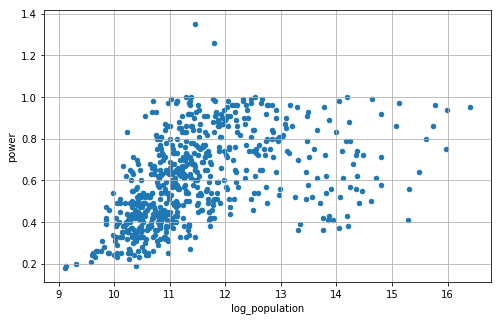

In [44]:
#以下データの可視化・分析
df_f.plot.scatter(x='log_population',y='power',grid=True,figsize=(8,5))

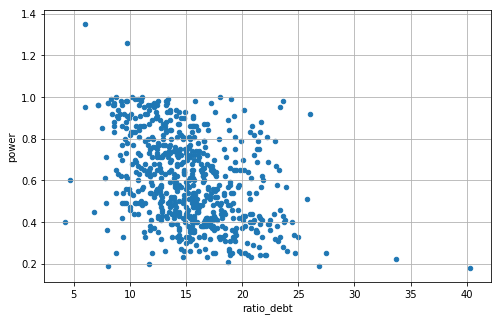

In [46]:
df_f.plot.scatter(x='ratio_debt',y='power',grid=True,figsize=(8,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a21a510f0>,
      dtype=object)

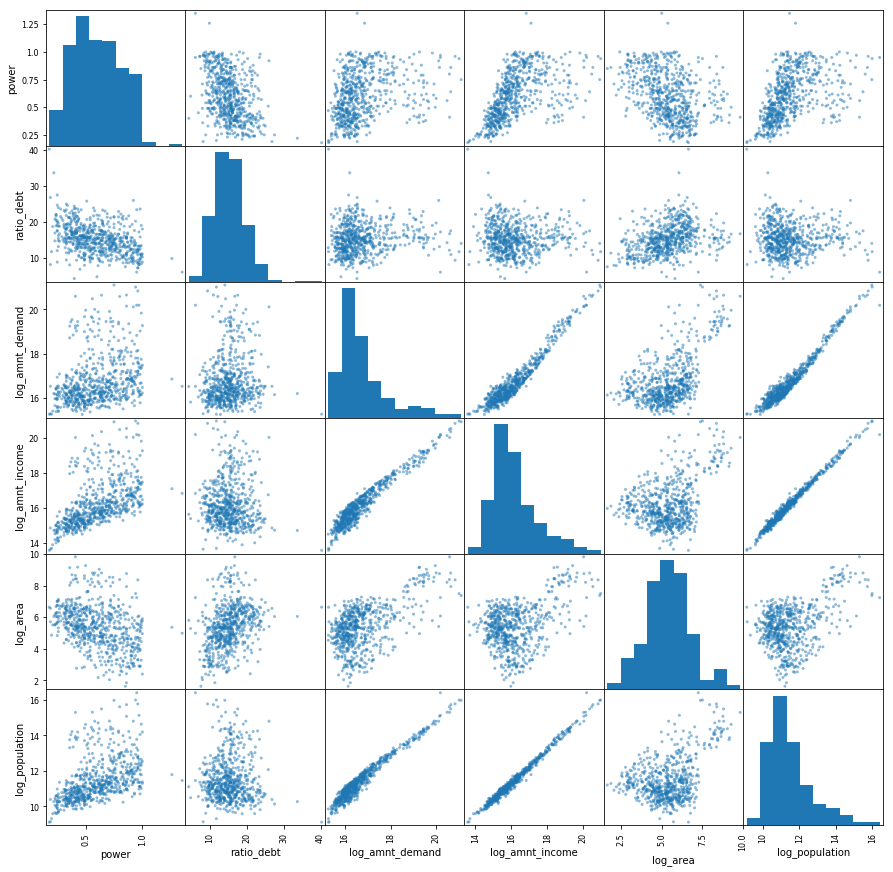

In [128]:
scatter_matrix(df_f[['power','ratio_debt','log_amnt_demand','log_amnt_income','log_area','log_population']], figsize=(15,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a22b1c978>,
      dtype=object)

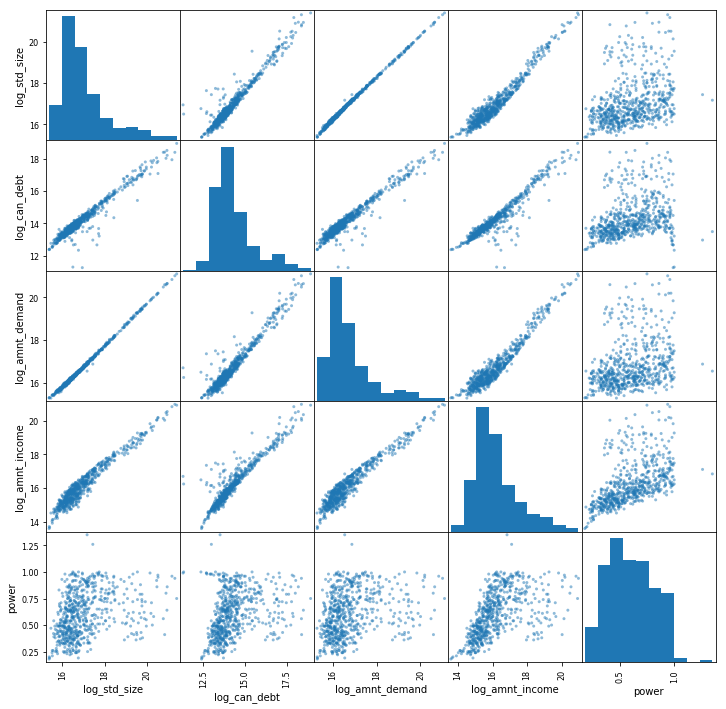

In [130]:
scatter_matrix(df_f[['log_std_size','log_can_debt','log_amnt_demand','log_amnt_income','power']], figsize=(12,12))

In [132]:
df_f[['log_std_size','log_can_debt','log_amnt_demand','log_amnt_income','power']].corr().round(4)

,log_std_size,log_can_debt,log_amnt_demand,log_amnt_income,power
log_std_size,1.0000,0.9638,0.9990,0.9701,0.3341
log_can_debt,0.9638,1.0000,0.9623,0.9379,0.3063
log_amnt_demand,0.9990,0.9623,1.0000,0.9627,0.3038
log_amnt_income,0.9701,0.9379,0.9627,1.0000,0.5424
power,0.3341,0.3063,0.3038,0.5424,1.0000


In [133]:
df_f[['log_std_size','log_population','log_area','log_can_debt','log_amnt_demand','log_amnt_income','power']].corr().round(4)

,log_std_size,log_population,log_area,log_can_debt,log_amnt_demand,log_amnt_income,power
log_std_size,1.0000,0.9802,0.5490,0.9638,0.9990,0.9701,0.3341
log_population,0.9802,1.0000,0.4156,0.9509,0.9760,0.9929,0.4729
log_area,0.5490,0.4156,1.0000,0.5146,0.5627,0.3908,-0.3680
log_can_debt,0.9638,0.9509,0.5146,1.0000,0.9623,0.9379,0.3063
log_amnt_demand,0.9990,0.9760,0.5627,0.9623,1.0000,0.9627,0.3038
log_amnt_income,0.9701,0.9929,0.3908,0.9379,0.9627,1.0000,0.5424
power,0.3341,0.4729,-0.3680,0.3063,0.3038,0.5424,1.0000


In [134]:
df_f[['log_amnt_demand','log_amnt_income','ratio_debt','pay_debt','pay_man','log_can_debt','power']].corr().round(4)

,log_amnt_demand,log_amnt_income,ratio_debt,pay_debt,pay_man,log_can_debt,power
log_amnt_demand,1.0000,0.9627,0.0909,0.0433,-0.0317,0.9623,0.3038
log_amnt_income,0.9627,1.0000,-0.0436,-0.0896,0.0125,0.9379,0.5424
ratio_debt,0.0909,-0.0436,1.0000,0.9198,-0.2147,0.1020,-0.4035
pay_debt,0.0433,-0.0896,0.9198,1.0000,-0.1632,0.0526,-0.4190
pay_man,-0.0317,0.0125,-0.2147,-0.1632,1.0000,-0.0393,0.1472
log_can_debt,0.9623,0.9379,0.1020,0.0526,-0.0393,1.0000,0.3063
power,0.3038,0.5424,-0.4035,-0.4190,0.1472,0.3063,1.0000


In [135]:
df_f[['log_future_bear','log_out_in_annual','log_out_in_actual','log_amnt_demand','log_amnt_income','power']].corr().round(4)

,log_future_bear,log_out_in_annual,log_out_in_actual,log_amnt_demand,log_amnt_income,power
log_future_bear,1.0000,-0.0018,-0.1212,0.0407,-0.0089,-0.1775
log_out_in_annual,-0.0018,1.0000,0.6514,0.6531,0.6044,0.1210
log_out_in_actual,-0.1212,0.6514,1.0000,0.7687,0.7493,0.2670
log_amnt_demand,0.0407,0.6531,0.7687,1.0000,0.9627,0.3038
log_amnt_income,-0.0089,0.6044,0.7493,0.9627,1.0000,0.5424
power,-0.1775,0.1210,0.2670,0.3038,0.5424,1.0000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1f03f470>,
      dtype=object)

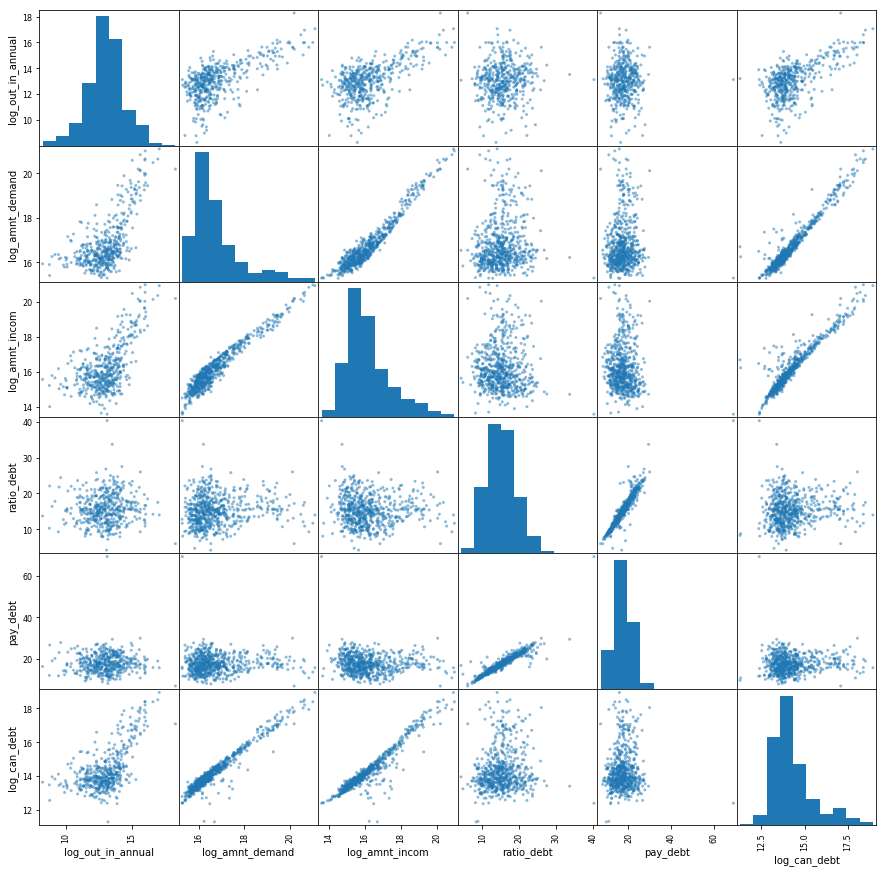

In [55]:
scatter_matrix(df_f[['log_out_in_annual','log_amnt_demand','log_amnt_incom','ratio_debt','pay_debt','log_can_debt']], figsize=(15,15))

In [ ]:
【可視化からわかること】
財政規模・需要額・収入額・発行可能債務額には強い正の相関がある.
    財政規模・需要額・収入額に共通する要因があることの示唆.
    仮説構築で示したように, 需要額と収入額は人口をベースとしたものであることから, この共通の要因は人口であることが推測される.
    面積は人口や収入額と比べて需要額とやや強い正の相関にある. インフラや道路網などは土地面積に比例的であるからだろう. 財政力指数とは負の相関
公債費・債務比率・将来負担には相関関係がある.
    財政力指数と債務比率には弱い負の相関がある.
    これらの債務関連の数値は, 財政力指数の要因というよりもむしろその結果と見る方が自然である.財政力指数の算出方法を見ればわかる.

In [ ]:
次に外れ値を排して分析する. 散布図を見ると, 需要額や収入額, 人口が上に突出しているものがいくつか見受けられたため.

In [136]:
#外れ値検出用の関数
def culc_outliner(item):
    q1 = df_f[item].describe()['25%']
    q3 = df_f[item].describe()['75%']
    iqr = q3 - q1 #四分位範囲
    outliner_max = q3 + (iqr) * 1.5
    return outliner_max

In [138]:
#人口,収入額,需要額についての外れ値(上方向)
pop_out = culc_outliner('log_population')
demand_out = culc_outliner('log_amnt_demand')
income_out = culc_outliner('log_amnt_income')

In [140]:
df_adjust = df_f[(df_f['log_population'] < pop_out)&(df_f['log_amnt_demand'] < demand_out)&(df_f['log_amnt_income'] < income_out)]

In [141]:
df_adjust.describe()

,population,area,amnt_demand,amnt_income,std_size,can_debt,ratio_actual,ratio_ordinary,pay_man,pay_debt,...,out_in_annual,log_population,log_area,log_amnt_demand,log_amnt_income,log_std_size,log_can_debt,log_out_in_annual,log_out_in_actual,log_future_bear
count,587.000000,587.000000,5.870000e+02,5.870000e+02,5.870000e+02,5.870000e+02,587.000000,587.000000,587.000000,587.000000,...,5.870000e+02,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000,421.000000,587.000000,587.000000
mean,107697.756388,300.545571,1.910926e+07,1.274846e+07,2.520736e+07,1.723078e+06,5.771721,90.010562,23.603407,17.348382,...,2.881194e+05,11.200744,5.158382,16.492662,15.910863,16.749770,13.995454,12.760546,13.670801,-inf
std,117402.609559,313.032604,1.818266e+07,1.514136e+07,2.474018e+07,2.052650e+06,4.513690,4.541503,3.431876,4.608674,...,8.925689e+05,0.830342,1.152032,0.677326,0.900531,0.705962,0.783234,1.179436,0.956636,NaN
min,9056.000000,5.110000,4.276430e+06,7.921790e+05,4.755135e+06,7.858600e+04,0.100000,66.400000,13.700000,7.900000,...,-5.728372e+06,9.111183,1.631199,15.268629,13.582543,15.374736,11.271949,8.253228,8.840580,-inf
25%,38923.000000,84.390000,8.850186e+06,4.176834e+06,1.134606e+07,7.082850e+05,3.300000,87.200000,21.200000,14.400000,...,-3.977800e+04,10.569340,4.435446,15.995948,15.245034,16.244381,13.470579,12.119659,13.180886,3.394503
50%,65074.000000,201.920000,1.261332e+07,7.180270e+06,1.646917e+07,1.045396e+06,5.200000,89.900000,23.500000,17.000000,...,2.235770e+05,11.083280,5.307872,16.350264,15.786848,16.617001,13.859906,12.928524,13.684172,4.037774
75%,121232.500000,426.635000,2.109926e+07,1.368276e+07,2.841105e+07,1.855314e+06,7.350000,92.900000,25.700000,19.950000,...,5.828455e+05,11.705465,6.055929,16.864749,16.431647,17.162288,14.433564,13.598646,14.257373,4.513055
max,735234.000000,2789.140000,1.241766e+08,1.077154e+08,1.656423e+08,1.902825e+07,77.100000,120.700000,36.400000,69.200000,...,4.737993e+06,13.507944,7.933489,18.637215,18.495004,18.925341,16.761435,15.371124,16.485805,6.449522


In [143]:
df_adjust[['log_population','power','log_amnt_income','log_amnt_demand']].corr().round(4)

,log_population,power,log_amnt_income,log_amnt_demand
log_population,1.0000,0.6223,0.9867,0.9487
power,0.6223,1.0000,0.7089,0.3915
log_amnt_income,0.9867,0.7089,1.0000,0.9214
log_amnt_demand,0.9487,0.3915,0.9214,1.0000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1ff805c0>,
      dtype=object)

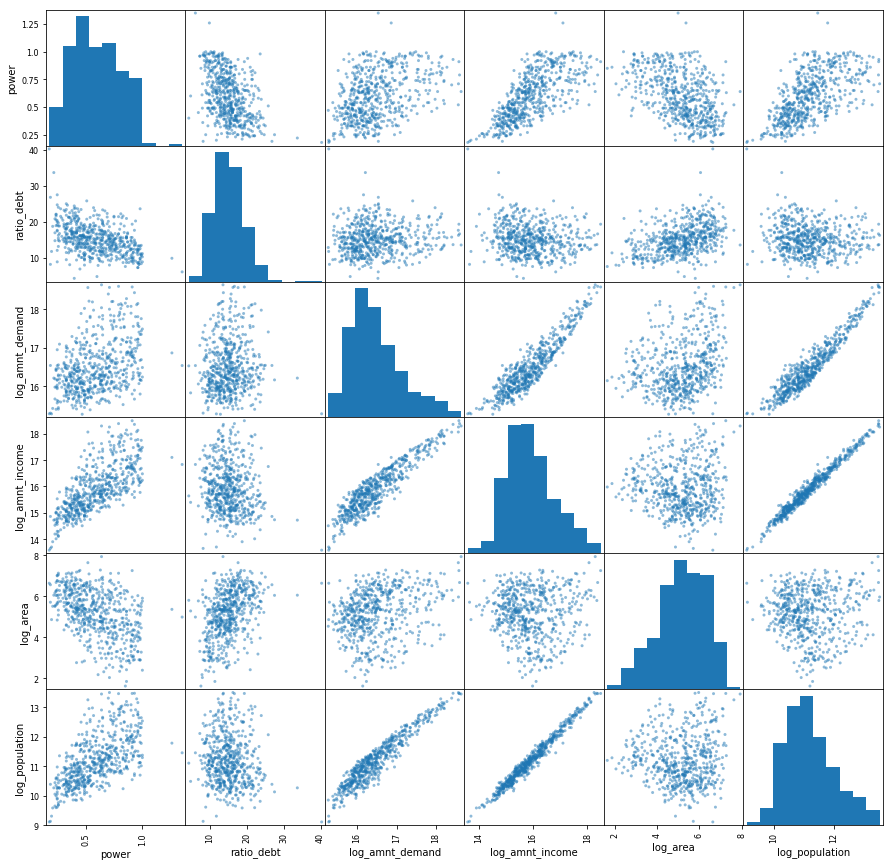

In [145]:
scatter_matrix(df_adjust[['power','ratio_debt','log_amnt_demand','log_amnt_income','log_area','log_population']], figsize=(15,15))

In [146]:
df_adjust[['power','ratio_debt','log_amnt_demand','log_amnt_income','log_area','log_population']].corr().round(4)

,power,ratio_debt,log_amnt_demand,log_amnt_income,log_area,log_population
power,1.0000,-0.4441,0.3915,0.7089,-0.4770,0.6223
ratio_debt,-0.4441,1.0000,0.0749,-0.1372,0.4135,-0.1075
log_amnt_demand,0.3915,0.0749,1.0000,0.9214,0.2669,0.9487
log_amnt_income,0.7089,-0.1372,0.9214,1.0000,-0.0009,0.9867
log_area,-0.4770,0.4135,0.2669,-0.0009,1.0000,0.0211
log_population,0.6223,-0.1075,0.9487,0.9867,0.0211,1.0000


In [ ]:
各値のあてはまりが, 仮説に沿って良くなっていることがわかる.

In [ ]:
【考察】
・人口が多い->税収も多ければ社会保障費など支出も多い。また, 財政力指数の多くを説明できる。
    すなわち, 人口の多寡に関わらず地域面積は一定程度あるので, 一定程度のインフラなど支出が必要になる。demandだけある状況.
    そのため, '人口が増えれば増えるほど税収が上がり, それを追う形で教育費など支出が増える'というケースが基本的であると推測される
・面積が広い->人口との相関は特にない(収入額が少ない)が, インフラなど支出が多くなる.
    直接の相関が薄いのは, 影響力は決して大きくはないから.
    ただし、需要額にはやや正の相関, 収入には無相関という差が財政力指数との負の相関に現れているのではないか
    公債への支払いが多いのもその結果の一側面と考えられる. 
        demandはほとんどが人口への支払いと道路などのインフラに依る。demandがあるけれどincomeが足りない->借金をする->財政力指数が足りないというフローがある？

In [ ]:
したがって, 人口,面積が基準財政需要/収入額の主要因と考えられる.
財政力指数は基準財政額と基準収入額から算出されるので,　財政力指数の主要因とも言える.

In [ ]:
以下, 財政力指数が線形回帰モデルで説明できると仮定して当てはまりのよさを検証してみる.
#需要と収入とがともに人口,面積の関数であるとすると, 線形結合で表すことができるのかどうかは不明な部分がある.

In [156]:
X=df_adjust[['log_amnt_demand','log_amnt_income','log_area','log_population']]
Y=df_adjust['power']
#'log_amnt_demand','log_amnt_income'で多重共線性の問題があると予想される
l_model = linear_model.LinearRegression()
mod = LinearRegression(fit_intercept = True, normalize = False, copy_X = True, n_jobs = 1)
# fit関数でパラメータ推定
mod.fit(X, Y)
clf = l_model.fit(X,Y)
print("test1:",clf.__class__.__name__ ,clf.score(X,Y))

test1: LinearRegression 0.964131816620062


In [149]:
X=df_adjust[['log_area','log_population']]
Y=df_adjust['power']

l_model = linear_model.LinearRegression()
mod = LinearRegression(fit_intercept = True, normalize = False, copy_X = True, n_jobs = 1)
# fit関数でパラメータ推定
mod.fit(X, Y)
clf = l_model.fit(X,Y)
print("test2:",clf.__class__.__name__ ,clf.score(X,Y))

test2: LinearRegression 0.6275733375422222


In [150]:
X=df_adjust[['log_amnt_demand','log_area','log_population']]
Y=df_adjust['power']

l_model = linear_model.LinearRegression()
mod = LinearRegression(fit_intercept = True, normalize = False, copy_X = True, n_jobs = 1)
# fit関数でパラメータ推定
mod.fit(X, Y)
clf = l_model.fit(X,Y)
print("test3:",clf.__class__.__name__ ,clf.score(X,Y))

test3: LinearRegression 0.7835340759365975


In [152]:
X=df_adjust[['log_amnt_income','log_area','log_population']]
Y=df_adjust['power']

l_model = linear_model.LinearRegression()
mod = LinearRegression(fit_intercept = True, normalize = False, copy_X = True, n_jobs = 1)
# fit関数でパラメータ推定
mod.fit(X, Y)
clf = l_model.fit(X,Y)
print("test4:",clf.__class__.__name__ ,clf.score(X,Y))

test4: LinearRegression 0.900549570869904


In [153]:
X=df_adjust[['log_area','log_population']]
Y=df_adjust['log_amnt_income']

l_model = linear_model.LinearRegression()
mod = LinearRegression(fit_intercept = True, normalize = False, copy_X = True, n_jobs = 1)
# fit関数でパラメータ推定
mod.fit(X, Y)
clf = l_model.fit(X,Y)
print("test5:",clf.__class__.__name__ ,clf.score(X,Y))

test5: LinearRegression 0.9740086621387811


In [155]:
X=df_adjust[['log_area','log_population']]
Y=df_adjust['log_amnt_demand']

l_model = linear_model.LinearRegression()
mod = LinearRegression(fit_intercept = True, normalize = False, copy_X = True, n_jobs = 1)
# fit関数でパラメータ推定
mod.fit(X, Y)
clf = l_model.fit(X,Y)
print("test6:",clf.__class__.__name__ ,clf.score(X,Y))

test6: LinearRegression 0.9611025109252201


In [ ]:
【結果】
線形モデルで表せるという仮定のもとで,
    ①人口と面積で財政力指数を6割ほど説明できる
    ②人口と面積で需要額・収入額の9割以上を説明できる
要因として有力であると考えられる.